[IRIS 꽃받침 길이, 너비, 꽃잎 길이 기반 꽃잎 너비 예측 모델 + 교차 검증]
- 데이터셋 : Iris
- 학습종류: 지도학습 / 회귀(Regression)
- 알고리즘: 분석 후 결정
- 피쳐: 꽃받침 길이, 꽃받침 너비, 꽃잎 길이 ==> 다변량
- 타겟: 꽃잎 너비
- 검증: 5개 교차 검증

[1] 모듈 로딩 및 데이터 준비

In [68]:
#[1-1] 모듈 로딩

import pandas as pd		# 데이터 분석 및 전처리용 모듈
import matplotlib.pyplot as plt  # 데이터 시각화
import numpy as np
import koreanize_matplotlib
from sklearn.model_selection import train_test_split # 학습용 /검증용 / 테스트용 데이터 분리 및 처리용 모듈
from sklearn.model_selection import KFold	# 교차검증

In [69]:
# 데이터 준비

irisDF = pd.read_csv('../Data/iris.csv', usecols=[0,1,2,3])

irisDF.head()

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


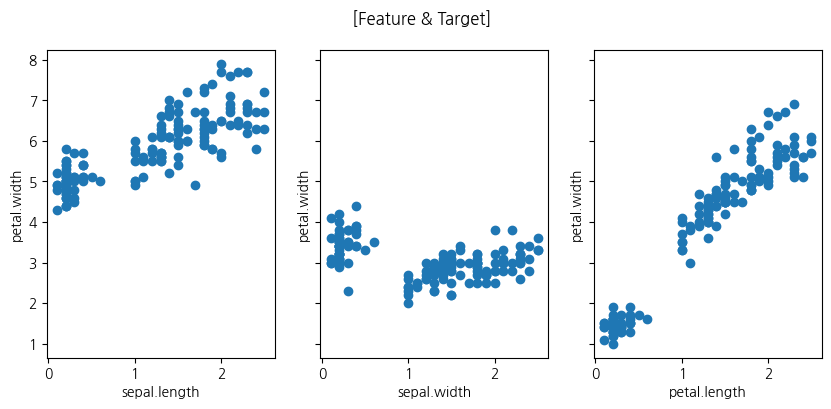

In [70]:
fig , axes = plt.subplots(1, 3, sharey=True, figsize=(10,4))

axes = axes.flatten()
titles = irisDF.columns[:-1]

for title, ax in zip(titles, axes):
    ax.scatter(irisDF['petal.width'], irisDF[title])
    ax.set_xlabel(title)
    ax.set_ylabel('petal.width')

plt.suptitle('[Feature & Target]')
plt.show()

In [71]:
irisDF.corr()['petal.width']

sepal.length    0.817941
sepal.width    -0.366126
petal.length    0.962865
petal.width     1.000000
Name: petal.width, dtype: float64

- 탐색적 분석의 결과
	* 알고리즘 : 선형회귀 => 규제선형 모델 Ridge, Lasso, ElasticNet
	* 선택 피쳐 : sepal.length , petal.length

[3] 데이터 셋 준비
- 학습용 데이터 셋: 학습에만 사용 > 해당 데이터셋에서 피쳐와 타겟의 규칙 / 패턴 탐색
- 검증용 데이터 셋: 학습 중 규칙 / 패턴 제대로 학습 여부 검사
- 테스트용 데이터 셋: 모델 완성 후 테스트용 데이터 셋
- sklearn 패키지 특성으로 학습용과 테스트용만 사용

In [72]:
irisDF.columns[:-1:2]

Index(['sepal.length', 'petal.length'], dtype='object')

In [73]:
# [3-1] 피쳐와 타겟 분리
featureDF = irisDF[irisDF.columns[:-1]] # feature 3개
targetSR = irisDF[irisDF.columns[-1]]

print(f" featureDF > {featureDF.ndim}D shape > {featureDF.shape}")
print(f" targetSR > {targetSR.ndim}D shape > {targetSR.shape}")


 featureDF > 2D shape > (150, 3)
 targetSR > 1D shape > (150,)


In [74]:
# [3-2]데이터 분리
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, random_state=5)

In [75]:
print(f'X_train => {X_train.ndim}D,   {X_train.shape}')
print(f'X_test => {X_test.ndim}D,   {X_test.shape}')

print(f'y_train => {y_train.ndim}D,   {y_train.shape}')
print(f'y_test => {y_test.ndim}D,   {y_test.shape}')


X_train => 2D,   (112, 3)
X_test => 2D,   (38, 3)
y_train => 1D,   (112,)
y_test => 1D,   (38,)


[4] 학습 진행 <hr>

In [76]:
# 모듈 로딩
from sklearn.linear_model import Ridge, Lasso, ElasticNet # 알고리즘 모듈
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error # 성능평가 관련 모듈
 

In [77]:
# 교차검증 객체 생성 -5개 분할 [기본]

kf = KFold()

# 선형회귀 모델 객체 생성
lr = Ridge()

In [ ]:
score_total = 0
loss_total = 0 


# - alpha 값에 따른 Ridge 모델 성능 비교
#resultDF = pd.DataFrame(columns=['score','loss'])
resultDF = pd.DataFrame(columns=['alpha','train_score','test_score','train_loss','test_loss'])
# 교차검증으로 학습 및 검증 진행

for alpha in [0.1,0.5,1.0,1.5,2]:
	# 선영회귀 모델 객체 생성
	lr = Ridge(alpha)

	train_stotal, test_stotal = 0,0
	train_ltotal, test_ltotal = 0,0

	for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
		#print(f"Fold {i}:")
		# print(f"  Train: index={train_index}")
		# print(f"  Test:  index={test_index}")

		# -학습용/테스트용 피쳐와 타겟 추출
		train_data, train_label = X_train.iloc[train_index], y_train.iloc[train_index]
		test_data, test_label = X_train.iloc[test_index], y_train.iloc[test_index]

		# 학습
		lr.fit(train_data, train_label)
		# 성능평가
		train_score = lr.score(train_data, train_label)
		test_score = lr.score(test_data,test_label)

		# - 손실계산
		train_loss = root_mean_squared_error(train_label, lr.predict(train_data))
		test_loss = root_mean_squared_error(test_label,lr.predict(test_data))

		# 성능값과 손실값 계산
		train_stotal += train_score
		test_stotal += test_score 
		train_ltotal += train_loss
		test_ltotal += test_loss

		# resultDF.loc[f'Train_{i}'] = [train_score,train_loss]
		# resultDF.loc[f'Test_{i}'] = [test_score,test_loss]

		# 

	# alpha 값 별로 성능과 손실값 평균 저장하기
	resultDF.loc[f'alpha_{alpha}']= [alpha,train_stotal/5,test_stotal/5,train_ltotal/5,test_ltotal/5]
	#train_stotal/5
	#결과학인

	# print(f"Train_score 평균 {score_total/5}")
	# print(f"loss_score 평균 {loss_total/5}")


In [82]:
resultDF

,alpha,train_score,test_score,train_loss,test_loss
alpha_0.1,0.1,0.941133,0.934375,0.185949,0.194070
alpha_0.5,0.5,0.940983,0.934377,0.186186,0.194026
alpha_1.0,1.0,0.940607,0.934165,0.186776,0.194294
alpha_1.5,1.5,0.940112,0.933811,0.187552,0.194774
alpha_2,2.0,0.939555,0.933380,0.188421,0.195370


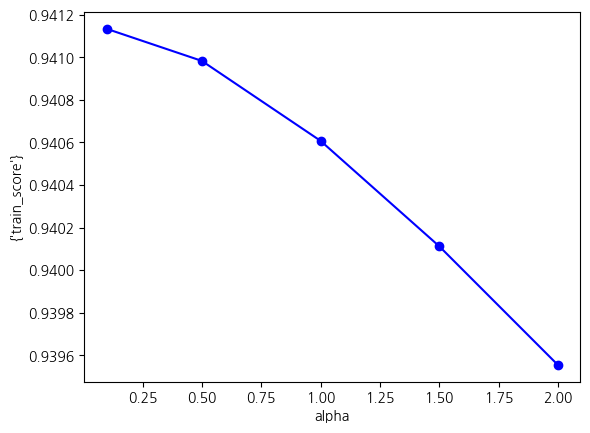

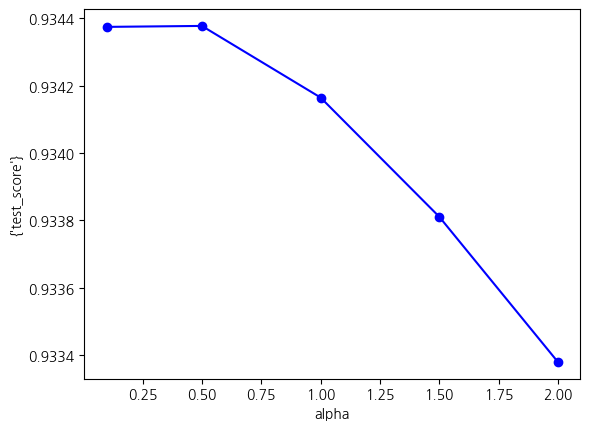

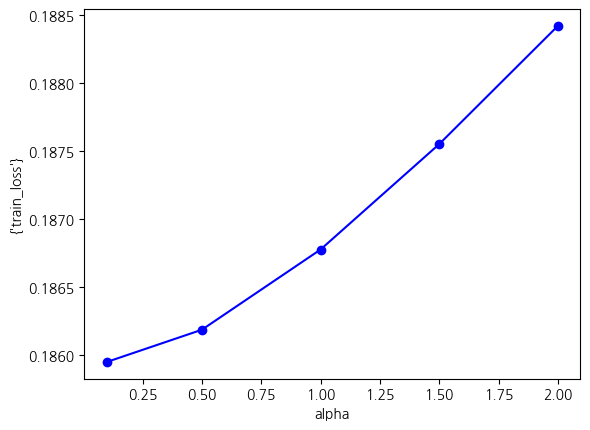

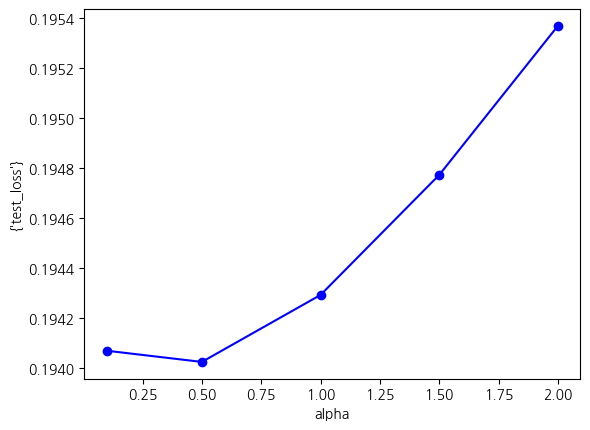

In [ ]:
for i in resultDF.columns[1:] :
	plt.plot(resultDF['alpha'],resultDF[i], 'bo-')
	plt.xlabel('alpha')
	plt.ylabel({i})
	plt.show()

# plt.plot(resultDF['alpha'],resultDF['train_score'], 'bo-')
# plt.plot(resultDF['alpha'],resultDF['test_score'], 'bo-')
# plt.show()

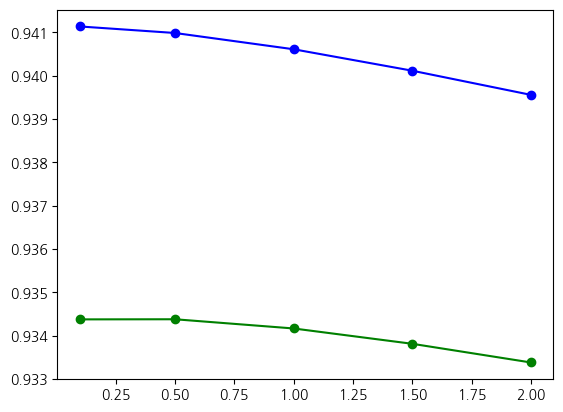

In [89]:
plt.plot(resultDF['alpha'],resultDF['train_score'], 'bo-')
plt.plot(resultDF['alpha'],resultDF['test_score'], 'go-')
plt.show()

In [ ]:
Train_score_sum = 0
Test_score_sum = 0
for i in resultDF.index :
	if i in 'Train':
		Train_score_sum += resultDF.loc[i,'score']
	else :
		Test_score_sum += resultDF.loc[i,'score']

print( Train_score_sum/5 ,   Test_score_sum/5)

0.0 1.875479589075225


In [ ]:
X_train.iloc[:4]

,sepal.length,sepal.width,petal.length
40,5.0,3.5,1.3
115,6.4,3.2,5.3
142,5.8,2.7,5.1
69,5.6,2.5,3.9


In [ ]:
resultDF = pd.DataFrame(columns=['score','loss'])
resultDF

,score,loss


In [ ]:
resultDF.loc['fold1'] = [0,0]
resultDF

,score,loss
fold1,0,0


[5] 테스트 수행<hr>

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
pred_y  = lr.predict(X_test)

pred_y 

# 평가
score = r2_score(y_test,pred_y)
rmse = root_mean_squared_error(y_test,pred_y)

print(score, rmse)


0.9272612455415583 0.19890584560279181


[6] 모델 활용/ 서비스 <hr>

In [ ]:
# # 사용자로 부터 입력 받기
# print('꽃받침 길이랑 넓이 조회 ')
# new_data =  input(' 입력 (예: 3.4,7.9) :').split(',')
# print(new_data)

# new_data = [float(data) for data in new_data]

# print(new_data)

In [ ]:
# 예측 결과 출력
# data_DF = pd.DataFrame([new_data], columns=['sepal.length','petal.length'])
# #print(lr.predict([new_data]))
# print(lr.predict(data_DF))